In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
import imageio.v2 as imageio
import os
from os import path
import time
import math
import random
# import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## Loading the dataset

In [29]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

In [30]:
X_train.shape

(60000, 28, 28)

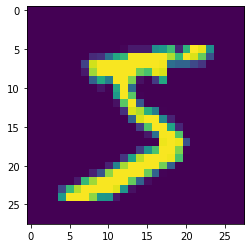

In [31]:
input = np.array(X_train[0])

plt.imshow(input)
plt.show()

In [32]:
# Parameters
image_train_time = 350

min_frequency = 1
max_frequency = 50

In [33]:
pixel_x = 28
T = 350

def rf(inp):
	sca1 =  0.625
	sca2 =  0.125
	sca3 = -0.125
	sca4 = -.5

	#Receptive field kernel
	w = [[	sca4 ,sca3 , sca2 ,sca3 ,sca4],
	 	[	sca3 ,sca2 , sca1 ,sca2 ,sca3],
	 	[ 	sca2 ,sca1 , 	1 ,sca1 ,sca2],
	 	[	sca3 ,sca2 , sca1 ,sca2 ,sca3],
	 	[	sca4 ,sca3 , sca2 ,sca3 ,sca4]]

	pot = np.zeros([pixel_x,pixel_x])
	ran = [-2,-1,0,1,2]
	ox = 2
	oy = 2

	#Convolution
	for i in range(pixel_x):
		for j in range(pixel_x):
			summ = 0
			for m in ran:
				for n in ran:
					if (i+m)>=0 and (i+m)<=pixel_x-1 and (j+n)>=0 and (j+n)<=pixel_x-1:
						summ = summ + w[ox+m][oy+n]*inp[i+m][j+n]/255
			pot[i][j] = summ
	return pot		




In [34]:

def encode(pot):

	#initializing spike train
	train = []

	for l in range(pixel_x):
		for m in range(pixel_x):
		
			temp = np.zeros([(T+1),])

			#calculating firing rate proportional to the membrane potential
			freq = np.interp(pot[l][m], [np.min(pot),np.max(pot)], [1,50])

				
			time_period = math.ceil(T/freq)

			#generating spikes according to the firing rate
			time_of_spike = time_period
			if(pot[l][m]>0):
				while time_of_spike<(T+1):
					temp[int(time_of_spike)] = 1
					time_of_spike+= time_period
			train.append(temp)
	return train


In [35]:
def encode_image_to_spike_train(image: np.ndarray):
    spike_trains = []

    for x_position in range(image.shape[0]):
        for y_position in range(image.shape[1]):

            pixel_value = image[x_position][y_position]

            spike_train = np.zeros(shape=(image_train_time+1,))

            # Transfer pixel value to set frequency range(and some other stuff, which interp does...)
            frequency = np.interp(pixel_value, [np.min(image),np.max(image)], [min_frequency,max_frequency])

            spike_time_distance = math.ceil(image_train_time / frequency)
            next_spike_time = spike_time_distance

            if pixel_value > 0:
                while next_spike_time < (image_train_time + 1):
                    # Add Spike to Spike Train
                    spike_train[int(next_spike_time)] = 1

                    # Calculate next spike
                    next_spike_time += spike_time_distance

            spike_trains.append(spike_train)

    return spike_trains


In [36]:
def receptive_field(image: np.ndarray):
    image_size_x = image.shape[0]
    image_size_y = image.shape[1]

    weight1 =  0.625
    weight2 =  0.125
    weight3 = -0.125
    weight4 = -.5

    # Receptive Field Kernel
    receptive_field = [
        [weight4 ,weight3 , weight2 ,weight3 ,weight4],
        [weight3 ,weight2 , weight1 ,weight2 ,weight3],
        [weight2 ,weight1 ,   1     ,weight1 ,weight2],
        [weight3 ,weight2 , weight1 ,weight2 ,weight3],
        [weight4 ,weight3 , weight2 ,weight3 ,weight4]]

    convoluted_image = np.zeros(shape=image.shape)

    window = [-2,-1,0,1,2]
    x_offset = 2
    y_offset = 2

    # Apply Convolution with Receptive Field Kernel
    for x_image_index in range(image_size_x):
        for y_image_index in range(image_size_y):
            summation = 0
            for x_kernel_index in window:
                for y_kernel_index in window:
                    if (x_image_index+x_kernel_index)>=0 and (x_image_index+x_kernel_index)<=image_size_x-1 and (y_image_index+y_kernel_index)>=0 and (y_image_index+y_kernel_index)<=image_size_y-1:
                        summation = summation + (receptive_field[x_offset+x_kernel_index][y_offset+y_kernel_index] * image[x_image_index+x_kernel_index][y_image_index+y_kernel_index]) / 255
            convoluted_image[x_image_index][y_image_index] = summation
    return convoluted_image


In [37]:
print((rf(input) == receptive_field(input)).all())
#print((encode(input) == encode_image_to_spike_train(input)).all())

np.array_equal(encode(rf(input)),encode_image_to_spike_train(rf(input))) 

True


True

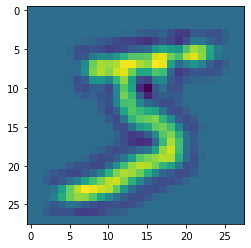

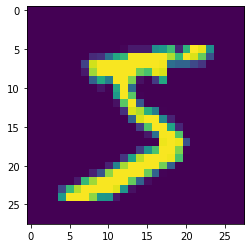

In [38]:
receptive_field_output = receptive_field(input)

plt.imshow(receptive_field_output)
plt.show()
plt.imshow(input)
plt.show()

In [39]:
# Simulation Parameters
image_train_time = 350 #Training time for every image
past_window = -5
epochs = 1

# Input Parameters
training_set_path= "./MNIST/training/"
image_size = (28,28)
resting_potential = -70
layer1_size = image_size[0] * image_size[1] # Number of neurons in first layer
# layer2_size =  800  # Number of neurons in second layer

# Neuron Parameters
inhibitory_potential = -100
spike_threshold = -55
hyperpolarization_potential = -90
# spike_drop_rate = 0.8
# threshold_drop_rate = 0.4
min_weight = 0.00001
max_weight = 1.0

# STDP Parameters
STDP_offset = 0
sigma = 0.01
A_plus = 0.8
A_minus = 0.8
tau_plus = 5
tau_minus = 5
mu=0.9

In [40]:
class Neuron:
	def hyperpolarization(self, time_step):
		self.potential = hyperpolarization_potential
		self.rest_until = time_step + self.refractory_period

	def inhibit(self, time_step):
		self.potential = inhibitory_potential
		self.rest_until = time_step + self.refractory_period

	def initial(self):
		self.adaptive_spike_threshold = spike_threshold
		self.rest_until = -1
		self.refractory_period = 15 #(us)
		self.potential = resting_potential

In [41]:
# STDP reinforcement learning curve
def STDP_weighting_curve(time_step: int):
	if time_step>0:
		return -A_plus*(np.exp(-float(time_step)/tau_plus)-STDP_offset)
	if time_step<=0:
		return A_minus*(np.exp(float(time_step)/tau_minus)-STDP_offset)


# STDP weight update rule
def update_synapse(synapse_weight, weight_factor):
	if weight_factor<0:
		return synapse_weight + sigma * weight_factor * (synapse_weight - abs(min_weight))**mu
	elif weight_factor>0:
		return synapse_weight + sigma * weight_factor * (max_weight - synapse_weight)**mu

In [42]:
def visualize_weights(weights, num):
	weights = np.array(weights)
	weights = np.reshape(weights, image_size)
	img = np.zeros(image_size)
	for x_coordinate in range(image_size[0]):
		for y_coordinate in range(image_size[1]):
			img[x_coordinate][y_coordinate] = int(np.interp(weights[x_coordinate][y_coordinate], [min_weight, max_weight], [0,255]))

	imageio.imwrite('Neurons/neuron_' + str(num) + '.png' ,img.astype(np.uint8))
	return img

In [50]:
def test(output_layer, synapses, labels_matrix, dataset, layer2_size = 100, spike_drop_rate=0.8, threshold_drop_rate=0.4):	
	#time series 
	time_of_learning = np.arange(1, image_train_time+1, 1)

	predicted_class=[]
	actual_class=[]
	prediction_count=np.zeros((layer2_size,layer2_size))

	for train in dataset:
		spike_train = train[1]
		folder = train[0]

		time_start = time.time()
		
		count_spikes = np.zeros((layer2_size,1))

		#initialize the potentials of output neurons
		for neuron in output_layer:
			neuron.initial()

		#flag for lateral inhibition
		current_potentials = np.zeros((layer2_size,1))
		winner_index = None
		for time_step in time_of_learning:
				for layer2_index, neuron in enumerate(output_layer):

					if(neuron.rest_until < time_step):
						neuron.potential = neuron.potential + np.dot(synapses[layer2_index], spike_train[:,time_step])

						if(neuron.potential>resting_potential):
							neuron.potential -= spike_drop_rate
							
					current_potentials[layer2_index] = neuron.potential

				winner_index = np.argmax(current_potentials)

				for layer2_index, neuron in enumerate(output_layer):
					if(layer2_index == winner_index):
						if(current_potentials[layer2_index] > neuron.adaptive_spike_threshold):
							count_spikes[layer2_index] += 1
							neuron.adaptive_spike_threshold += 1
							neuron.hyperpolarization(time_step)

							for looser_neuron_index, looser_neuron in enumerate(output_layer):
								if looser_neuron_index != winner_index:
									if(looser_neuron.potential>looser_neuron.adaptive_spike_threshold):
										looser_neuron.inhibit(time_step)
							break
		
		predicted = labels_matrix[np.argmax(count_spikes)]
		predicted_class.append(predicted)
		actual_class.append(folder)
		prediction_count[int(folder)][int(labels_matrix[np.argmax(count_spikes)])]+=1
	
	correct = 0
	for i in range(len(predicted_class)):
		if int(predicted_class[i]) == int(actual_class[i]):
			correct = correct + 1
	accuracy = correct / len(predicted_class)

	np.savetxt("prediction_matrix.csv",prediction_count,delimiter=',')
	return accuracy

In [44]:
def preprocess_data(path, number_of_pictures):
    dataset = []
    for index, folder in enumerate(os.listdir(path)):
        for image_path in os.listdir(path + folder + "/")[:number_of_pictures]:
            img = imageio.imread(path + folder + "/" + image_path)
            spike_train = np.array(encode_image_to_spike_train(receptive_field(img)))
            dataset.append((folder, spike_train))
    return dataset

In [45]:
def train(layer1_size, layer2_size=100, spike_drop_rate=0.8, threshold_drop_rate=0.4, epochs=1, number_of_pictures=80, checkpoint_interval=0):
    if number_of_pictures > 4000:
        print("Number of pictures is to large")
        return

    print("Converting data...")
    training_dataset = preprocess_data("./MNIST/training/", number_of_pictures)
    test_dataset = preprocess_data("./MNIST/testing/", 10)
    print("...done")
    potentials = []
    potential_thresholds = []
    for image_path in range(layer2_size):
        potentials.append([])
        potential_thresholds.append([])

    time_of_learning = np.arange(1, image_train_time + 1, 1)

    output_layer = []
    accuracy = []

    # Creating Second Layer
    for image_path in range(layer2_size):
        neuron = Neuron()
        neuron.initial() # TODO In die __init__()
        output_layer.append(neuron)

    # Random synapse matrix	initialization
    # synapses = np.random.uniform(low=0.95, high=1.0, size=(layer2_size , layer1_size)) # 
    synapses = np.ones((layer2_size , layer1_size)) 
    max_weight = np.max(synapses)
    synapse_memory = np.zeros((layer2_size ,layer1_size))

    # Creating labels corresponding to neuron
    label_neuron = np.repeat(-1 , layer2_size)

    for epoch in range(epochs):
        print("Epoch: " + str(epoch))
        for train in training_dataset:
            spike_train = train[1]
            folder = train[0]

            # Local variables
            winner_index = None
            count_spikes = np.zeros(layer2_size)
            current_potentials = np.zeros(layer2_size)

            synapse_memory = np.zeros((layer2_size ,layer1_size))

            # Leaky integrate and fire neuron dynamics
            for time_step in time_of_learning:

                for neuron_index, neuron in enumerate(output_layer):
                    if(neuron.rest_until < time_step):
                        # Increase potential according to the sum of synapses inputs
                        neuron.potential += np.dot(synapses[neuron_index], spike_train[: , time_step])

                        if(neuron.potential > resting_potential):
                            neuron.potential -= spike_drop_rate

                            if(neuron.adaptive_spike_threshold > spike_threshold):
                                    neuron.adaptive_spike_threshold -= threshold_drop_rate
                                    
                        current_potentials[neuron_index] = neuron.potential

                    potentials[neuron_index].append(neuron.potential) # Only for plotting: Changing potential overtime
                    potential_thresholds[neuron_index].append(neuron.adaptive_spike_threshold) # Only for plotting: Changing threshold overtime

                winner_index = np.argmax(current_potentials)
                winner_neuron = output_layer[winner_index]

                # Check for spikes and update weights
                if current_potentials[winner_index] > winner_neuron.adaptive_spike_threshold:
                    count_spikes[winner_index] += 1

                    winner_neuron.hyperpolarization(time_step)
                    winner_neuron.adaptive_spike_threshold += 1 # Adaptive Membrane/Homoeostasis: Increasing the threshold of the neuron

                    for layer1_index in range(layer1_size):
                        for past_time_step in range(0, past_window-1, -1): # if presynaptic spike came before postsynaptic spike
                            if 0 <= time_step + past_time_step < image_train_time + 1:
                                if spike_train[layer1_index][time_step + past_time_step] == 1:  # if presynaptic spike was in the tolerance window
                                    synapses[winner_index][layer1_index] = update_synapse(synapses[winner_index][layer1_index], STDP_weighting_curve(past_time_step))  # strengthen weights
                                    synapse_memory[winner_index][layer1_index] = 1
                                    break
                        if synapse_memory[winner_index][layer1_index] != 1:  # if presynaptic spike was not in the tolerance window, reduce weights of that synapse
                            synapses[winner_index][layer1_index] = update_synapse(synapses[winner_index][layer1_index], STDP_weighting_curve(1))

                    # Inhibit all LOOSERS
                    for looser_neuron_index, looser_neuron in enumerate(output_layer):
                        if looser_neuron_index != winner_index:
                            if (looser_neuron.potential > looser_neuron.adaptive_spike_threshold):
                                count_spikes[looser_neuron_index] += 1

                            looser_neuron.inhibit(time_step)

            # bring neuron potentials to rest
            for neuron_index, neuron in enumerate(output_layer):
                neuron.initial()

            label_neuron[winner_index] = int(folder)

        for layer2_index in range(layer2_size):
            if label_neuron[layer2_index] == -1:
                for layer1_index in range(layer1_size):
                    synapses[layer2_index][layer1_index] = 0

        # Storing weights and labels when the checkpoint interval has been reached
        if checkpoint_interval != 0:
            if epoch % checkpoint_interval == 0:
                if not path.exists("Neurons"):
                    os.mkdir("Neurons")

                if not path.exists("visualized_weights"):
                    os.mkdir("visualized_weights")

                timestamp = str(time.time())
                weights_path = "visualized_weights/weights" + timestamp + ".csv"
                labels_path = "visualized_weights/labels" + timestamp + ".csv"
                for layer2_index in range(layer2_size):
                    visualize_weights(synapses[layer2_index], str(layer2_index) + "_final")
                np.savetxt(weights_path, synapses, delimiter=",")
                np.savetxt(labels_path, label_neuron, delimiter=',')
        acc = test(output_layer, synapses, label_neuron, test_dataset, layer2_size, spike_drop_rate, threshold_drop_rate)
        print("Accucarcy at epoch " + str(epoch) + ": " + str(acc))
        accuracy.append(acc)

    return accuracy

In [46]:
def test_spike_drop():
    spike_drop_rates = [0.6, 0.7, 0.8, 0.9]
    threshold_drop_rates = [0.2, 0.3, 0.4, 0.5]
    for i in range(0, 4):
        accuracy = train(layer1_size, 800, spike_drop_rates[i], threshold_drop_rates[i], 5)
        print("Spike drop rate: " + str(spike_drop_rates[i]) + "\nThreshold drop rate: " + str(threshold_drop_rates[i]) + "\nNumber of epochs: " + str(5) + "\nAccuracy: " + ", ".join(str(e) for e in accuracy) + "\n\n")

In [105]:
accuracies = []
layer_sizes = [10, 50, 100, 200, 400, 800, 1000]
for layer in layer_sizes:
    accuracies.append({"Neurons":layer, "Accuracy":train(layer1_size, layer2_size=layer, epochs=5)})
    print(accuracies)
print(accuracies)

Converting data...


KeyboardInterrupt: 

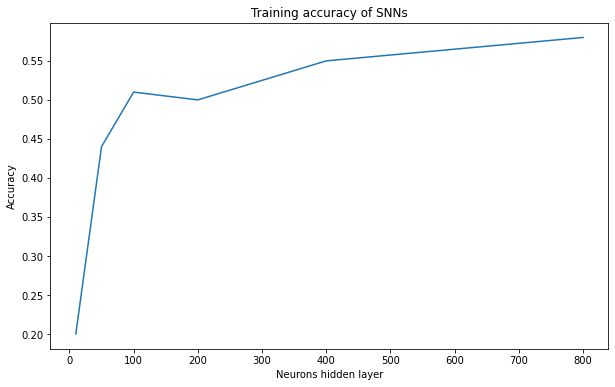

In [ ]:
x = [e["Accuracy"][0] for e in accuracies]
y = [e["Neurons"] for e in accuracies]

plt.figure(figsize=(10, 6))
plt.title("Training accuracy of SNNs")
plt.ylabel('Accuracy')
plt.xlabel('Neurons hidden layer')
plt.plot(y[:-1], x[:-1])

In [49]:
accuracies = []
image_sizes = [40, 80, 160, 320, 640, 1280]
for number in image_sizes:
    accuracies.append({"Images":number, "Accuracy":train(layer1_size, layer2_size=800, epochs=3, number_of_pictures=number)})
    print(accuracies)
print(accuracies)

Converting data...
...done
Epoch: 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 5, 1, 3, 8, 8, 1, 1, 1, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 8, 0, 8, 5, 8, 3, 8, 9, 3, 3, 4, 4, 0, 4, 0, 4, 4, 4, 0, 0, 5, 5, 8, 0, 6, 8, 5, 0, 6, 5, 0, 0, 6, 0, 0, 0, 0, 8, 0, 6, 7, 7, 9, 7, 8, 7, 7, 8, 9, 7, 8, 8, 8, 8, 8, 8, 4, 8, 2, 0, 7, 2, 9, 5, 8, 0, 9, 9, 2, 7]
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '8', '8', '8', '8', '8', '8', '8', '8', '8', '8', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9']


C:\Users\wolff\AppData\Local\Temp\ipykernel_64352\3657520479.py:57: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  accuracy=(np.sum(np.array(predicted_class)==np.array(actual_class))/len(predicted_class))*100


Accucarcy at epoch 0: 0.54
Epoch: 1


KeyboardInterrupt: 